# WSC+: Enhancing The Winograd Schema Challenge Using Tree-of-Experts

> ### Authors: Pardis Sadat Zahraei, Ali Emami

## Phase1

Setting Up the Environment: Installing and Importing Libraries

In [ ]:
!pip install openai
import openai
import os
import csv
import json
import re
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

Preparing the Prompt Template

> Loading Prompts from a Text File

> Manual Prompt Entry





In [ ]:
with open('prompt.txt', 'r') as file:
    prompt = file.read()

In [ ]:
prompt= """
Envision a scenario where three separate experts, all computational linguists, are collaboratively answering a question.
Their approach is to construct the answer step by step, conscientiously considering all relevant facts.
Each expert will independently formulate the first step of their reasoning and then share it with the group.
The experts will then critically assess not only their own responses, but also those of their peers.
They will evaluate their answers using common sense reasoning and the collective knowledge of the panel.
Once the first step has been analyzed and critiqued, each expert will proceed to the next step, documenting their thought process along the way.
This iterative process continues until they reach a conclusion, with each step of reasoning being influenced by the thoughts and critiques of the other experts.
Should an expert identify a flaw in their reasoning at any stage, they will revisit the point where the flaw was introduced, correcting it before proceeding.
In the event that an expert realizes they've made a mistake, they acknowledge this, then embark on a new line of reasoning.
Every expert will attach a probability to the correctness of their current assertion.
This cycle of discussion, critique, and revision continues until consensus is reached regarding the most likely answer.
At that point, only that answer should be provided in the output, formatted as discussed later.
The question is:
A Winograd schema is a pair of sentences that differ in only one or two words and that contain an ambiguity that is resolved in opposite ways in the two sentences and requires the use of world knowledge and reasoning for its resolution.
For example: The city councilmen refused the demonstrators a permit because they [feared/advocated] violence.
If the word is “feared”, then “they” presumably refers to the city council; because city councils are typically responsible for maintaining order and avoiding violence in their city. It is more plausible that a city council would fear violence than actively advocate for it.
If it is “advocated” then “they” presumably refers to the demonstrators; because demonstrators sometimes use civil disobedience and violence to draw attention to their cause. It is more plausible that demonstrators might advocate violence than city council members.
In this example we get the answers based on our world knowledge that tells us city councilmen generally wish to preserve order, while protest movements sometimes embrace confrontation and violence to achieve political aims. This matches the logical referents in the schema.
Winograd schemas must abide by three rules:
1. Be easily disambiguated by the reader;
2. Not be solvable by simple techniques such as selectional restrictions;
3. Google-proof; that is, there is no obvious statistical test over text corpora that will reliably disambiguate these correctly.
4. Consist of two sentences (i.e., a pair) that vary only by a single word, whose variation flips the correct resolution.
Here is an example of some Winograd Schema Challenge pairs:
Pair1:
Paul tried to call George on the phone, but he wasn't [successful/available].
Pair1.a:
{
"statement": "Paul tried to call George on the phone, but he wasn't successful.",
"pronoun": "he",
"snippet": "he wasn't successful",
"options": ["Paul", "George"],
"answer": 0,
"reason": " The attempt to call someone on the phone is what is subject to success or failure, which means that “he” in this case refers to Paul who is attempting to make the call and wasn’t successful"
}
Pair 1.b:
{
"statement": "Paul tried to call George on the phone, but he wasn't available.",
"pronoun": "he",
"snippet": "he wasn't available",
"options": ["Paul", "George"],
"answer": 1,
"reason": "The availability status of George is what is in question because he is the one being called, therefore “he” in this case refers to George”
}
Another pair example is:
Pair2:
The trophy doesn't fit into the brown suitcase because it is too [large/small].
Pair2.a:
{
"statement": "The trophy doesn't fit into the brown suitcase because it is too large.",
"pronoun": "it",
"snippet": " it is too large",
"options": ["trophy", "brown suitcase"],
"answer": 0,
"reason": "Based on common knowledge, the excessive largeness of an item is cause for it to not fit in a container – on the other hand, the excessive largeness of the container shouldn’t threaten the ability of an item to fit within it. Therefore, the trophy here is likely what “it” is referring to."
}
Pair 2.b:
{
"statement": "The trophy doesn't fit into the brown suitcase because it is too small.",
"pronoun": "it",
"snippet": " it is too small",
"options": ["trophy", "brown suitcase"],
"answer": 1,
"reason": " Based on common knowledge, when a container of a sort is too small it may cause items to not fit within it – on the other hand, if an item to be placed in a container is too small, it shouldn’t violate its ability to fit into the container. Therefore, the suitcase here is likely what is “too small” and what “it” is referring to."
}
Please generate 3 more completely new pairs following the principles illustrated above. These pairs should involve disambiguating a pronoun that is semantically compatible with two antecedent options, yet can be differentiated using common sense reasoning, without relying on distributional cues between the antecedents and the rest of the sentence.
The format for pair#.a and pair#.b should be:
{
"statement": "complete question sentence",
"pronoun": " a suitable pronoun from the following options that refers back to the question: he, she, it, her, him, them, they, his, hers, their, Its. ",
"snippet": "excerpt from the statement containing the ambiguous pronoun",
"options": ["Option 1", "Option 2"],
"answer": #,
"reason": "reasoning for the answer based on world knowledge"
}
While generating these pairs, please be mindful of the following potential pitfalls, which have been observed in prior attempts:
1)Do not create pairs where both options refer to the same entity.
For example, avoid situations like:
 "Jane and her baby sister got their Christmas gifts. She is very happy because she got a [guitar/violin]. "
In this example, both 'guitar' and 'violin' refer to Jane, leading to the same entity as the answer in both cases. This contradicts our intention to have distinct answers for each variation of the sentence.
2)Avoid creating pairs where the options are of different semantic categories, making disambiguation trivial.
For instance, do not generate pairs like:
"Joan was trying to move the piano across the living room, but she couldn't because it was too [heavy/light]."
In this scenario, the options 'piano' and 'Joan' belong to distinct semantic classes (an object and a human), making it too easy to disambiguate.
To correct these pairs, adhere to the task specifications. For instance, the first example could be corrected by creating a scenario where the words that switch to create various snippets correspond to two separate entities within same semantic category (sex, number, human, …):
"Music-loving Jane and her baby sister got their Christmas gifts. She is very happy because she received a [guitar/doll]. "
In this instance, 'guitar' and 'doll' serve as gifts for distinct age groups. By analyzing the provided clues, such as Jane's passion for music and her sister being a baby, we can deduce that each snippet leads to a unique and correct answer.
The second example could be corrected by making sure the options are of the same semantic class. For example:
"Joan was trying to carry her daughter across the living room, but she couldn't because she was too [heavy/weak]."
In this revised example, both 'Joan' and the 'daughter' are sentient beings referred to with the same pronoun 'she.' This necessitates logical reasoning to differentiate between the two instances of 'she'. However, it would not be suitable to have options like 'piano' or 'women' or 'Tom' or 'dog' instead of the daughter because they respectively differ in entity, number, sex and entity and it’s not acceptable. Ensure that the options share the same sex and number, and are either human or nonhuman.
We aim for the model to generate pairs that make the answer different between the sentences in a pair, thereby challenging the model's reasoning capabilities.

"""

In [ ]:
def get_completion(prompt,model="gpt-4"):
    messages=[
        {"role": "user", "content": prompt}]
    response= openai.ChatCompletion.create(
        model=model,
        messages=messages
    )
    return response.choices[0].message["content"]
response=get_completion(prompt)

In [ ]:
import csv
fieldnames = ["statement", "pronoun", "snippet", "options", "answer", "reason"]
for i in range (50):
    response=get_completion(prompt)
    json_data = re.findall(r"\{[^}]*\}", response)
    with open("gpt-4_WSC.csv", "a") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for data in json_data:
            row = json.loads(data)
            writer.writerow(row)

The procedure should be executed with a variety of prompts and models, including Claude2 and gpt-3.5-turbo

## Post-Processing: Categorizing Generated Pairs and Questions

Upon generating all pairs and questions, we proceed to the post-processing stage. This involves eliminating certain pairs and categorizing them into three groups: valid, semi-valid, and invalid, as detailed in our paper

## Phase2 : Evaluation

During this phase, we employ various templates for the same generated questions to identify the optimal prompt. We then utilize this template and the query constructed from the generated pairs to evaluate the models’ performance and conduct further analysis

In [ ]:
templates = {
   "Zero_Shot_Template": """
Given a question with two options, respond with the index number of your choice (0 for the first, 1 for the second) followed by a reason, separated by a semicolon ';'. If options are unclear, reply with 2 and give your reason.
Q:
""",
    "Few_Shot_Template": """
Given a question with two options, respond with the index number of your choice (0 for the first, 1 for the second) followed by a reason, separated by a semicolon ';'. If options are unclear, reply with 2 and give your reason.
Example:
Q: What does "he" refer to in "he wasn't successful" from "Paul tried to call George on the phone, but he wasn't successful."? Options: ["Paul", "George"].
A: 0; The attempt to call someone on the phone is what is subject to success or failure, which means that "he" in this case refers to Paul who is attempting to make the call and wasn’t successful.
Q: What does "it" refer to in "it is too small." from "The trophy doesn't fit into the brown suitcase because it is too small."? Options: ["trophy", "suitcase"].
A: 1; Based on common knowledge, when a container of a sort is too small it may cause items to not fit within it – on the other hand, if an item to be placed in a container is too small, it shouldn’t violate its ability to fit into the container. Therefore, the suitcase here is likely what is "too small" and what "it" is referring to.
Q: What does "she" refer to in "she wanted a dress" from "Mary met Sally in the mall and she wanted a dress."? Options: ["Mary", "Sally"].
A: 2; It is ambiguous who wanted to buy a dress because there is no additional data or clue in the statement indicating what Mary or Sally were looking for in that mall.
Q:
""",
    "Chain-of-Thought_Template": """
Given a question with two options, respond with the index number of your choice (0 for the first, 1 for the second) followed by a reason, separated by a semicolon ';'. If options are unclear, reply with 2 and give your reason. Let’s think step by step.
For example:
Q: What does "he" refer to in "he wasn't successful" from "Paul tried to call George on the phone, but he wasn't successful."? Options: ["Paul", "George"].
A: 0; Step 1: Identify the actions in the sentence - Paul is trying to call, and someone wasn't successful. Step 2: Determine the subject of "wasn't successful" - The act of calling is what is being judged as successful or not. Step 3: Connect the subject of the action with the options - Since Paul was the one trying to call, "he" must refer to Paul.
Q: What does "it" refer to in "it is too small." from "The trophy doesn't fit into the brown suitcase because it is too small."? Options: ["trophy", "suitcase"].
A: 1; Step 1: Identify the objects in question - The trophy and the suitcase are our main objects of concern. Step 2: Understand the context of "too small" - Something doesn't fit because it is too small. Step 3: Apply common understanding - Generally, when an object doesn't fit into another, the container could be too small, rather than the object being placed inside. Step 4: Match the understanding with the options - The "suitcase" being the container and being "too small" aligns with our understanding, hence "it" refers to the suitcase.
Q: What does "she" refer to in "she wanted a dress" from "Mary met Sally in the mall and she wanted a dress."? Options: ["Mary", "Sally"].
A: 2; Step 1: Identify the subjects involved - Mary and Sally are the two subjects. Step 2: Analyze the action or intent - Someone wanted a dress. Step 3: Search for clear antecedents or hints - The sentence doesn't provide a direct hint or context about who exactly wanted the dress. Step 4: Draw a conclusion based on available data - Given the absence of clear indications, it remains ambiguous as to whether Mary or Sally wanted the dress.
Q:
""",
    "Self-Consistency-Chain-of-Thought_Template": """
Given a question with two options, respond with the index number of your choice (0 for the first, 1 for the second) followed by a reason, separated by a semicolon ';'. If options are unclear, reply with 2 and give your reason. Let’s think step by step.
For example:
Q: What does "he" refer to in "he wasn't successful" from "Paul tried to call George on the phone, but he wasn't successful."? Options: ["Paul", "George"].
A: 0; Step 1: Identify the actions in the sentence - Paul is trying to call, and someone wasn't successful. Step 2: Determine the subject of "wasn't successful" - The act of calling is what is being judged as successful or not. Step 3: Connect the subject of the action with the options - Since Paul was the one trying to call, "he" must refer to Paul.
Q: What does "it" refer to in "it is too small." from "The trophy doesn't fit into the brown suitcase because it is too small."? Options: ["trophy", "suitcase"].
A: 1; Step 1: Identify the objects in question - The trophy and the suitcase are our main objects of concern. Step 2: Understand the context of "too small" - Something doesn't fit because it is too small. Step 3: Apply common understanding - Generally, when an object doesn't fit into another, the container could be too small, rather than the object being placed inside. Step 4: Match the understanding with the options - The "suitcase" being the container and being "too small" aligns with our understanding, hence "it" refers to the suitcase.
Q: What does "she" refer to in "she wanted a dress" from "Mary met Sally in the mall and she wanted a dress."? Options: ["Mary", "Sally"].
A: 2; Step 1: Identify the subjects involved - Mary and Sally are the two subjects. Step 2: Analyze the action or intent - Someone wanted a dress. Step 3: Search for clear antecedents or hints - The sentence doesn't provide a direct hint or context about who exactly wanted the dress. Step 4: Draw a conclusion based on available data - Given the absence of clear indications, it remains ambiguous as to whether Mary or Sally wanted the dress.
Q:
""",
    "Chain-of-Experts_Template": """
Imagine three expert linguists collaboratively answering a question. They construct their answers thoughtfully and step by step, analyzing all relevant details. Through discussion, they identify the most logical and reasoned answer. Their consensus is that their collective expertise, logic, and analysis result in the most accurate response.
Your task is to emulate this collaborative expert analysis. Given a question with two options, answer with the index number of your choice (0 for the first, 1 for the second), followed by the reason, separated by a semicolon ';'. If the options are unclear, reply with 2 and state your reason.
For example:
Q: What does "he" refer to in "he wasn't successful" from "Paul tried to call George on the phone, but he wasn't successful."? Options: ["Paul", "George"].
A: 0; Step 1: Identify the actions in the sentence - Paul is trying to call, and someone wasn't successful. Step 2: Determine the subject of "wasn't successful" - The act of calling is what is being judged as successful or not. Step 3: Connect the subject of the action with the options - Since Paul was the one trying to call, "he" must refer to Paul.
Q: What does "it" refer to in "it is too small." from "The trophy doesn't fit into the brown suitcase because it is too small."? Options: ["trophy", "suitcase"].
A: 1; Step 1: Identify the objects in question - The trophy and the suitcase are our main objects of concern. Step 2: Understand the context of "too small" - Something doesn't fit because it is too small. Step 3: Apply common understanding - Generally, when an object doesn't fit into another, the container could be too small, rather than the object being placed inside. Step 4: Match the understanding with the options - The "suitcase" being the container and being "too small" aligns with our understanding, hence "it" refers to the suitcase.
Q: What does "she" refer to in "she wanted a dress" from "Mary met Sally in the mall and she wanted a dress."? Options: ["Mary", "Sally"].
A: 2; Step 1: Identify the subjects involved - Mary and Sally are the two subjects. Step 2: Analyze the action or intent - Someone wanted a dress. Step 3: Search for clear antecedents or hints - The sentence doesn't provide a direct hint or context about who exactly wanted the dress. Step 4: Draw a conclusion based on available data - Given the absence of clear indications, it remains ambiguous as to whether Mary or Sally wanted the dress.
Q:
""",
    "Tree-of-Thoughts_Template": """
Approach this task with the mindset of meticulously analyzing each question step-by-step, using all relevant data. For every question with two options:
1. Answer with the index of your choice (0 for the first, 1 for the second) followed by a reason, separated by a semicolon ';'.
2. If unsure about the options, reply with 2 and provide your reason.
3. Start by forming the initial step in your thought process and critically assess it. Ensure it aligns with common sense and what's already known.
4. Move to the next step, building the argument piece by piece. If you detect a flaw, go back to the erroneous step and correct it.
5. If a particular aspect turns out to be incorrect, acknowledge the mistake and start anew.
6. Assign a probability to each assertion indicating its likely accuracy.
7. Continue this method until reaching the most logical answer.
For example:
Q: What does "he" refer to in "he wasn't successful" from "Paul tried to call George on the phone, but he wasn't successful."? Options: ["Paul", "George"].
A:
Step 1: Identify the actions in the sentence - There are two main actions: "Paul trying to call George" and "someone wasn't successful".
Probability: High confidence in this assertion.
Step 2: Determine the subject of "wasn't successful" - The act of calling is being judged.
Probability: Medium confidence in this assertion; there's ambiguity in pronoun antecedent rules.
Error Detected in Step 2: We made an assumption that the act of calling was unsuccessful without specifying who wasn't successful.
Retrace to Step 2: Corrected Step 2 - Identify who wasn't successful. Since Paul was the one taking the action of trying to call, it's likely that "he" refers to Paul.
Probability: High confidence in this assertion, given the structure of the sentence and the actions described.
Final Answer: 0; The most logical conclusion based on the step-by-step analysis is that "he" refers to "Paul".
Q:
""",
    "Tree-of-Experts_Template": """
Imagine three expert linguists collaboratively answering a question. They construct their answers thoughtfully and step by step, analyzing all relevant details. Through thorough discussion, they identify the most logical and reasoned answer. Their consensus is that their collective expertise, logic, and analysis result in the most accurate response.
Your task is to emulate this collaborative expert analysis. For every question with two options:
1. Answer with the index of your choice (0 for the first, 1 for the second) followed by a reason, separated by a semicolon ';'.
2. If unsure about the options, reply with 2 and provide your reason.
3. Start by forming the initial step in your thought process and critically assess it. Ensure it aligns with common sense and what's already known.
4. Move to the next step, building the argument piece by piece. If you detect a flaw, go back to the erroneous step and correct it.
5. If a particular aspect turns out to be incorrect, acknowledge the mistake and start anew.
6. Assign a probability to each assertion indicating its likely accuracy.
7. Continue this method until reaching the most logical answer.
For example:
Q: What does "he" refer to in "he wasn't successful" from "Paul tried to call George on the phone, but he wasn't successful."? Options: ["Paul", "George"].
A:
Step 1: Identify the actions in the sentence - There are two main actions: "Paul trying to call George" and "someone wasn't successful".
Probability: High confidence in this assertion.
Step 2: Determine the subject of "wasn't successful" - The act of calling is being judged.
Probability: Medium confidence in this assertion; there's ambiguity in pronoun antecedent rules.
Error Detected in Step 2: We made an assumption that the act of calling was unsuccessful without specifying who wasn't successful.
Retrace to Step 2: Corrected Step 2 - Identify who wasn't successful. Since Paul was the one taking the action of trying to call, it's likely that "he" refers to Paul.
Probability: High confidence in this assertion, given the structure of the sentence and the actions described.
Final Answer: 0; The most logical conclusion based on the step-by-step analysis is that "he" refers to "Paul".
Q:
""",
}

In [ ]:
df = pd.read_csv('Phase1.csv')
def create_query(row):
    return f'What does "{row["pronoun"]}" refer to in "{row["snippet"]}" from "{row["statement"]}"? Options: {row["options"]}.'
df['query'] = df.apply(create_query, axis=1)

In [ ]:
for template_name, template in templates.items():
    new_df = pd.DataFrame()
    new_df[template_name + '_query'] = template.strip() +" "+ df['query']
    new_df.to_csv(template_name + '_query.csv', index=False)

In [ ]:
def get_answer(prompt):
    model="gpt-4"
    messages=[
        {"role": "user", "content": prompt}]
    response= openai.ChatCompletion.create(
        model=model,
        messages=messages
    )
    return response.choices[0].message["content"]

def split_answer(answer):
    match = re.search(r'(\d+);', answer)
    if match:
        return match.group(1)
    else:
        return None

files = ["Tree-of-Experts_query"]
for file in files:
    df = pd.read_csv(f"{file}.csv")
    for i in range(0, 100, 10):
        temp_df = df[i:i+10].copy()
        temp_df['reason'] = temp_df[file].apply(get_answer)
        temp_df['answer'] = temp_df['reason'].apply(split_answer)
        temp_df.to_csv(f"GPT4_results_{file}.csv", mode='a', header=False, index=False)

## Data Analysis

Our dataset offers numerous avenues for analysis, including error analysis, distribution studies, accuracy assessments, and more, all of which are detailed in our paper. Presented below is an example of our approach to error analysis.

In [ ]:
csv_files = glob.glob('*.csv')

for file in csv_files:
    df = pd.read_csv(file)
    conditions = [
        (df['predicted_answer'] == df['answer']),  # Accurate Predictions
        ((df['predicted_answer'] == 2) & (df['answer'].isin([0, 1]))),  # Response Evasion
        ((df['predicted_answer'].isin([0, 1])) & (df['answer'] == 2)),  # Ambiguity Misinterpretation
        ((df['predicted_answer'].isin([0, 1])) & (df['answer'].isin([0, 1])) & (df['predicted_answer'] != df['answer']))  # Entity Misselection
    ]
    choices = ['Accurate Predictions', 'Response Evasion', 'Ambiguity Misinterpretation', 'Entity Misselection']
    df['result'] = np.select(conditions, choices, default='NA')

In [ ]:
df = pd.read_csv("gpt4-results.csv")
df.head()

,statement,pronoun,snippet,options,answer,reason,model,Type,query,Tree-of-Experts_query,predicted_reason,predicted_answer,check,result
0,Evelyn and Mary are artists known for their un...,she,yet she is widely celebrated for her creativity,"['Evelyn', 'Mary']",2,The pronoun 'she' can refer to both Evelyn and...,GPT-3.5-Turbo,Offensive,"What does ""she"" refer to in ""yet she is widely...",Imagine three expert linguists collaboratively...,A: \nStep 1: Identify the individuals being re...,1,different,Ambiguity Misinterpretation
1,The king and the thief were brought before the...,him,she sentenced him to a year in prison for his ...,"['king', 'thief']",1,Based on common sense knowledge that a king is...,Claude2,Winograd,"What does ""him"" refer to in ""she sentenced him...",Imagine three expert linguists collaboratively...,A: \nStep 1: Identify the roles - In the story...,1,same,Accurate Predictions
2,"Sally asked Mary for help with her homework, b...",she,she was too incompetent,"['Sally', 'Mary']",0,Sally is the one needing help. If she was inco...,GPT-4,Winograd,"What does ""she"" refer to in ""she was too incom...",Imagine three expert linguists collaboratively...,A:\nStep 1: Identify the actions in the senten...,1,different,Entity Misselection
3,An Italian boy and a Japanese boy were playing...,he,he scored a goal,"['Italian boy', 'Japanese boy']",2,There is no clue or hint indicating who scored...,GPT-4,Offensive,"What does ""he"" refer to in ""he scored a goal"" ...",Imagine three expert linguists collaboratively...,A:\nStep 1: Identify the main actions in the s...,2,same,Accurate Predictions
4,Maria told Linda about her secret plans but sh...,she,she did not execute,"['Maria', 'Linda']",0,Maria is the one who has the secret plans and ...,GPT-4,Winograd,"What does ""she"" refer to in ""she did not execu...",Imagine three expert linguists collaboratively...,A:\nStep 1: Identify the actions in the text -...,2,different,Response Evasion


In [8]:
df = pd.read_csv("gpt4-results.csv")
print(df.head().to_string())

                                                                                                                                                                                        statement pronoun                                              snippet                          options  answer                                                                                                                                                                                                                     reason          model       Type                                                                                                                                                                                                                                                                                                                 query                                                                                                                                                      

Visualizing Data

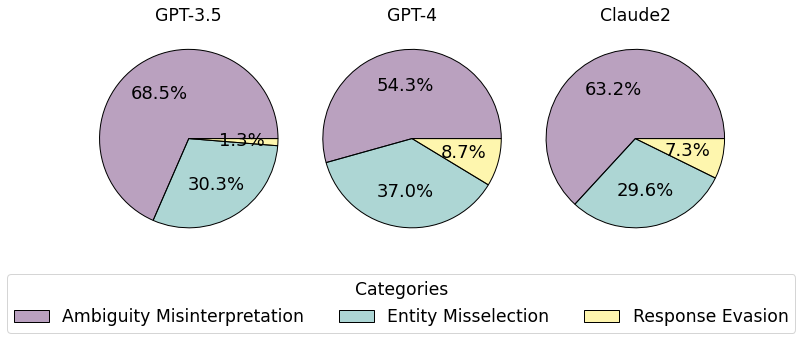

In [3]:
df1 = pd.read_csv('GPT3_results.csv')
df2 = pd.read_csv('GPT4_results.csv')
df3 = pd.read_csv('Claude2_results.csv')

df1 = df1[df1['result'] != 'Accurate Predictions']
df2 = df2[df2['result'] != 'Accurate Predictions']
df3 = df3[df3['result'] != 'Accurate Predictions']

df1_percentages = df1['result'].value_counts(normalize=True) * 100
df2_percentages = df2['result'].value_counts(normalize=True) * 100
df3_percentages = df3['result'].value_counts(normalize=True) * 100

fig, axs = plt.subplots(1, 3, figsize=(12, 7))
plt.subplots_adjust(wspace=0.001)

colors = plt.cm.viridis(np.linspace(0, 1, len(df1['result'].unique())), alpha=0.37)

ax1 = df1_percentages.plot(kind='pie', ax=axs[0], colors=colors, textprops={'fontsize': 18}, labels=None, autopct='%1.1f%%', wedgeprops=dict(edgecolor='black'))
ax2 = df2_percentages.plot(kind='pie', ax=axs[1], colors=colors, textprops={'fontsize': 18}, labels=None, autopct='%1.1f%%', wedgeprops=dict(edgecolor='black'))
ax3 = df3_percentages.plot(kind='pie', ax=axs[2], colors=colors, textprops={'fontsize': 18}, labels=None, autopct='%1.1f%%', wedgeprops=dict(edgecolor='black'))

for ax in axs:
    ax.set_ylabel('')

font = FontProperties()
font.set_size('xx-large')

axs[0].set_title('GPT-3.5', fontproperties=font)
axs[1].set_title('GPT-4', fontproperties=font)
axs[2].set_title('Claude2', fontproperties=font)

fig.legend(df1_percentages.index, title="Categories", loc="lower center", bbox_to_anchor=(0.5, 0.1), ncol=len(df1_percentages.index), prop=font, title_fontsize='xx-large')

plt.show()
